In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

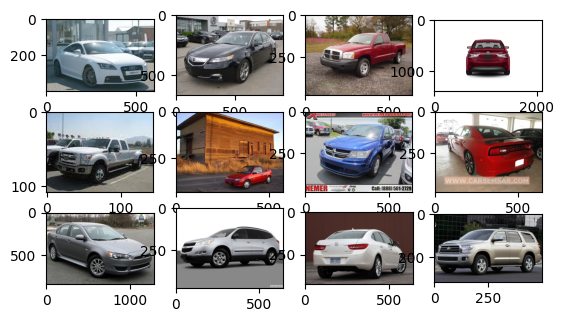

In [3]:
data = torchvision.datasets.StanfordCars(root='./',download=False)

for i, image in enumerate(data):
    if i == 12:
        break
    plt.subplot(int(12/4)+1, 4, i+1)
    plt.imshow(image[0])


In [4]:
class ForwardProcess:
    def __init__(self, timesteps, start=0.0001, end=0.03):
        """
        Initialize the forward process with beta schedule and precompute terms.
        """
        self.timesteps = timesteps
        self.betas = self.sample_beta(start, end, timesteps)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)

    def sample_beta(self, start, end, timesteps):
        """
        Generate a linear beta schedule.
        """
        return torch.linspace(start, end, timesteps)
    
    def get_index_from_list(self, values, t, shape):
        """
        Fetch a specific index t of a list of precomputed values, while respecting batch size.
        """
        batch_size = t.shape[0]
        out = values.gather(-1, t.cpu())
        return out.reshape(batch_size, *((1,) * (len(shape) - 1))).to(t.device)
    
    def add_noise(self, image, t, device="cpu"):
        """
        Add noise to an image at a specific timestep t using the forward process formula.
        """
        # batch_size = image.shape[0]
        # t = torch.tensor([time_step] * batch_size, device=device).long()

        # Generate random noise
        noise = torch.randn_like(image)

        # Get the appropriate scaling factors for timestep t
        sqrt_alpha_t = self.get_index_from_list(self.sqrt_alphas_cumprod, t, image.shape)
        sqrt_one_minus_alpha_t = self.get_index_from_list(self.sqrt_one_minus_alphas_cumprod, t, image.shape)

        # Apply the forward process formula
        noisy_image = sqrt_alpha_t.to(device) * image.to(device) + sqrt_one_minus_alpha_t.to(device) * noise.to(device)
        return noisy_image, noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04083926..1.0381111].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1568705..2.117086].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.338548..3.256967].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1920867..3.9013388].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.272095..4.1573315].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.517618..4.688758].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.6175604..4.

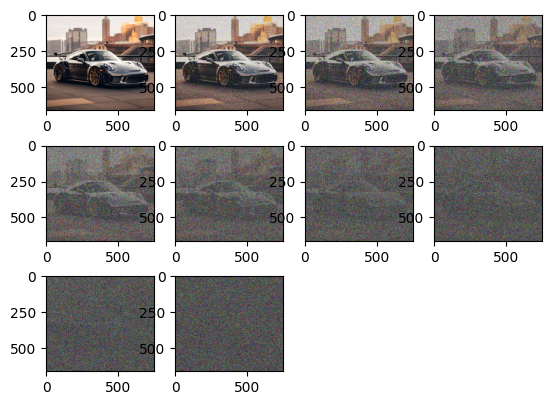

In [5]:
image = cv2.imread("/home/niru/Downloads/car.jpg")
image = torch.from_numpy(image).float().permute(2, 0, 1).unsqueeze(0) / 255.

forward_process = ForwardProcess(500)

for i in range(0, 500, 50):
    t = torch.tensor([i] * 1).long()
    noisy_image, noise = forward_process.add_noise(image, t)
    noisy_image = noisy_image.squeeze().permute(1, 2, 0).numpy()

    noisy_image = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB)
    
    plt.subplot(int(10/4)+1, 4, i//50+1)
    plt.imshow(noisy_image)
    

In [6]:
IMG_SIZE = 64
BATCH_SIZE = 128

def load_dataset():
    transform = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t*2)-1)
    ]

    data_transform = transforms.Compose(transform)

    train_data = torchvision.datasets.StanfordCars(root='./',download=False, transform=data_transform)
    test_data = torchvision.datasets.StanfordCars(root='./',download=False, transform=data_transform, split='test')

    return torch.utils.data.ConcatDataset([train_data, test_data])  

def tensorImage_to_numpyImage(tensor_image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

dataset = load_dataset()

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


In [7]:
from torch import nn
import math


# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Device: ", device)


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))


Num params:  62438883


In [8]:
forward_process = ForwardProcess(500)
def get_loss(model, x_0, t):
    noisy_image, noise = forward_process.add_noise(x_0, t, device)
    noise_pred = model(noisy_image, t)
    return F.l1_loss(noise.to(device), noise_pred.to(device))

In [9]:
from torch.optim import Adam

model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 1000 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, 500, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")

# Save the model
torch.save(model.state_dict(), "model.pth")

Epoch 0 | step 000 Loss: 0.8084325790405273 
Epoch 5 | step 000 Loss: 0.12409721314907074 
Epoch 10 | step 000 Loss: 0.11274616420269012 
Epoch 15 | step 000 Loss: 0.10221286863088608 
Epoch 20 | step 000 Loss: 0.10375561565160751 
Epoch 25 | step 000 Loss: 0.1161641776561737 
Epoch 30 | step 000 Loss: 0.1133633702993393 
Epoch 35 | step 000 Loss: 0.1143474206328392 
Epoch 40 | step 000 Loss: 0.09613139927387238 
Epoch 45 | step 000 Loss: 0.09570875018835068 
Epoch 50 | step 000 Loss: 0.09723663330078125 
Epoch 55 | step 000 Loss: 0.08910946547985077 
Epoch 60 | step 000 Loss: 0.11318834125995636 
Epoch 65 | step 000 Loss: 0.08790230751037598 
Epoch 70 | step 000 Loss: 0.10138057172298431 
Epoch 75 | step 000 Loss: 0.10188816487789154 
Epoch 80 | step 000 Loss: 0.10775192826986313 
Epoch 85 | step 000 Loss: 0.096827432513237 
Epoch 90 | step 000 Loss: 0.09759896993637085 
Epoch 95 | step 000 Loss: 0.09121552109718323 
Epoch 100 | step 000 Loss: 0.08747651427984238 
Epoch 105 | step 000

KeyboardInterrupt: 